In [173]:
from platform import python_version
import tensorflow as tf

print(tf.test.is_gpu_available())
print(python_version())

False
3.7.5


In [174]:
import os
import numpy as np
from os import listdir
from PIL import Image
import time
import tensorflow as tf
from tensorflow.keras import layers,models,optimizers
from keras import backend as K
import matplotlib.pyplot as plt

In [175]:
path1="datasets/ofg_family/"
path2="datasets/TSKinFace_Data/TSKinFace_cropped/"

randomiser = np.random.RandomState(123)

In [176]:
def generate_image_1(family_dir):
    dic={}
    sub=[a for a in listdir(path1+"/"+family_dir)]
    
    for ele in sub:
        if ele == '.DS_Store':
            continue;
        mypath = path1+"/"+family_dir+"/"+ele+"/"
        onlyfiles = [mypath+f for f in listdir(mypath)]
        
        addr = randomiser.choice(onlyfiles)
        original_img = np.array(Image.open(addr).resize((64,64),Image.ANTIALIAS))
        if ele[0].lower()=='f':
            dic['father'] = original_img
        elif ele[0].lower()=='m':
            dic['mother'] = original_img
        elif ele.lower()=='child_male':
            dic['child'] = original_img    
            dic['gender']=np.zeros((original_img.shape))
        elif ele.lower()=='child_female':
            dic['child'] = original_img    
            dic['gender'] = np.ones((original_img.shape))
    return [dic['father'],dic['mother'],dic['gender'],dic['child']]

def generate_image_2(family_dir, family_number, gender):
    dic={}
    sub = ["F" , "M", gender]
    family_pth = path2+"/"+family_dir+"/" + family_dir + "-" + str(family_number) + "-"
    for ele in sub:
        addr = family_pth+ele+".jpg"
        original_img = np.array(Image.open(addr).resize((64,64),Image.ANTIALIAS))
        if ele =='F':
            dic['father'] = original_img
        elif ele == 'M':
            dic['mother'] = original_img
        elif ele == 'S':
            dic['child'] = original_img    
            dic['gender']=np.zeros((original_img.shape))
        elif ele == 'D':
            dic['child'] = original_img    
            dic['gender'] = np.ones((original_img.shape))
    return [dic['father'],dic['mother'],dic['gender'],dic['child']]

def generate_batch(families_batch):
    np_images=[]
    for family in families_batch:
        if(len(family) == 3):
            res = generate_image_2(family[0], family[1], family[2])
        elif(len(family) == 1):
            res = generate_image_1(family[0])
        if( res != None):
            np_images.append(res)
    
    return np_images

In [177]:
for r, d, f in os.walk(path1):
        all_families = d
        break      
all_families = [[family] for family in all_families] 

for i in range(285):
    all_families.append(['FMS', i+1, 'S'])
for i in range(274):
    all_families.append(['FMD', i+1, 'D'])
    
for i in range(228):
    all_families.append(['FMSD', i+1, 'D'])  
    all_families.append(['FMSD', i+1, 'S'])  


randomiser.shuffle(all_families)

train_families = all_families[:-500]
test_families = all_families[-500:]


In [178]:
OUTPUT_CHANNELS = 3

In [179]:
mean = 0.
std_dev = 0.02
lr = 0.0001
b1 = 0.5
sd_random_normal_init = 0.02

EPOCHS = 20
batch = 125

In [180]:
def gen_downsample_parent(filters, size, apply_batchnorm=True, apply_dropout=False):
    initializer = tf.random_normal_initializer(mean, std_dev) 
  

    result = tf.keras.Sequential()
    result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer,
                             use_bias=False))

    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())
        
    result.add(tf.keras.layers.ELU())
        
    if apply_dropout:
        result.add(tf.keras.layers.Dropout(rate = 0.5))

    return result

In [181]:
def gen_downsample_noise(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(mean, std_dev) 
  

    result = tf.keras.Sequential()
    result.add(
      tf.keras.layers.Conv2DTranspose(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer,
                             use_bias=False))

    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())
        
    result.add(tf.keras.layers.ELU())

    return result

In [182]:
def gen_upsample(filters, size,apply_batchnorm = False):
    initializer = tf.random_normal_initializer(mean, std_dev)

    result = tf.keras.Sequential()
    result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                   use_bias=False))
    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())
        result.add(tf.keras.layers.ELU())

    return result

In [183]:
def EncoderNN():
    down_stack_parent = [
    gen_downsample_parent(32,4,apply_batchnorm=True, apply_dropout=True),
    gen_downsample_parent(64,4,apply_batchnorm=True, apply_dropout=False)
    ]
    
    down_stack_noise =[
#   z = 4x4x64
    gen_downsample_noise(64,4,apply_batchnorm=True), #8x8x64
    gen_downsample_noise(32,4,apply_batchnorm=True) #16x16x32      
    ]
    
    final_conv =[
        gen_upsample(32,4 ,apply_batchnorm = True)
    ]
    
    initializer = tf.random_normal_initializer(mean, sd_random_normal_init)
    last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh')

    concat = tf.keras.layers.Concatenate()

    father = tf.keras.layers.Input(shape=(64,64,3))
    mother = tf.keras.layers.Input(shape=(64,64,3))

    
#     create noise 4x4x64
#     noise = tf.random.normal((1,4,4,64),mean=0.0,stddev=1.0,dtype=tf.dtypes.float32)
#     print(noise.shape)
    
    
    x1 = father
    for down in down_stack_parent:
        x1 = down(x1)
    
#     print(x1.shape)
    
    x2 = mother
    for down in down_stack_parent:
        x2 = down(x2) 
    
#     print(x2.shape)
    
#     n = noise
#     for down in down_stack_noise:
#         print(n.shape)
#         n = down(n)
#     print(n.shape)
#     print("NOISE STACK DONE")
    
    final = concat([x1,x2])
    final = final_conv[0](final)
    
    final = last(final)

    return tf.keras.Model(inputs=[father, mother], outputs=final)

In [184]:
encoder_optimizer = tf.keras.optimizers.Adam(learning_rate = lr, beta_1=b1)

In [185]:
def tensor_to_array(tensor1):
    return tensor1.numpy()

In [186]:
def train_encoder(father_batch, mother_batch, target_batch, b_size):
    with tf.GradientTape() as enc_tape:
        gen_outputs = encoder([father_batch, mother_batch], training=True)
        
        diff = tf.abs(target_batch - gen_outputs)
        flatten_diff = tf.reshape(diff, (b_size, 64*64*3))
        
        encoder_loss_batch = tf.reduce_mean(flatten_diff, axis=1)
        encoder_loss = tf.reduce_mean(encoder_loss_batch)
    
    print("ENCODER_LOSS: ",tensor_to_array(encoder_loss))
    #calculate gradients
    encoder_gradients = enc_tape.gradient(encoder_loss,encoder.trainable_variables)

    #apply gradients on optimizer
    encoder_optimizer.apply_gradients(zip(encoder_gradients,encoder.trainable_variables))
    


In [187]:
def fit_encoder(train_ds, epochs, test_ds, batch):
    losses=np.array([])
    for epoch in range(epochs):
        print("______________________________EPOCH %d_______________________________"%(epoch+1))
        start = time.time()
        for i in range(len(train_ds)//batch):
            batch_data = np.asarray(generate_batch(train_ds[i*batch:(i+1)*batch]))
            batch_data = batch_data / 255 * 2 -1
            
            
            print("Generated batch", batch_data.shape)

            X_Father_train = tf.convert_to_tensor(batch_data[:,0],dtype =tf.float32)
            X_Mother_train = tf.convert_to_tensor(batch_data[:,1],dtype =tf.float32)
            Y_train = tf.convert_to_tensor(batch_data[:,3],dtype =tf.float32)
            
            train_encoder(X_Father_train, X_Mother_train, Y_train,batch)
            
            print("Trained for batch %d/%d"%(i+1,(len(train_ds)//batch)))
    print("______________________________TRAINING COMPLETED_______________________________")

In [ ]:
train_dataset = all_families[:-500]
test_dataset = all_families[-500:]
encoder = EncoderNN()

with tf.device('/cpu:0'):
   fit_encoder(train_dataset, EPOCHS, test_dataset,batch)


______________________________EPOCH 1_______________________________
Generated batch (125, 4, 64, 64, 3)
ENCODER_LOSS:  0.45636222
Trained for batch 1/20
Generated batch (125, 4, 64, 64, 3)
ENCODER_LOSS:  0.4445233
Trained for batch 2/20
Generated batch (125, 4, 64, 64, 3)
ENCODER_LOSS:  0.44525728
Trained for batch 3/20
Generated batch (125, 4, 64, 64, 3)
ENCODER_LOSS:  0.44256628
Trained for batch 4/20
Generated batch (125, 4, 64, 64, 3)
ENCODER_LOSS:  0.43532428
Trained for batch 5/20
Generated batch (125, 4, 64, 64, 3)
ENCODER_LOSS:  0.4375167
Trained for batch 6/20
Generated batch (125, 4, 64, 64, 3)
ENCODER_LOSS:  0.43636015
Trained for batch 7/20
Generated batch (125, 4, 64, 64, 3)
ENCODER_LOSS:  0.42230347
Trained for batch 8/20
Generated batch (125, 4, 64, 64, 3)
ENCODER_LOSS:  0.4096912
Trained for batch 9/20
Generated batch (125, 4, 64, 64, 3)
ENCODER_LOSS:  0.41038734
Trained for batch 10/20
Generated batch (125, 4, 64, 64, 3)
ENCODER_LOSS:  0.40989134
Trained for batch 11/

ENCODER_LOSS:  0.35789198
Trained for batch 13/20
Generated batch (125, 4, 64, 64, 3)
ENCODER_LOSS:  0.36665782
Trained for batch 14/20
Generated batch (125, 4, 64, 64, 3)
ENCODER_LOSS:  0.36433873
Trained for batch 15/20
Generated batch (125, 4, 64, 64, 3)
ENCODER_LOSS:  0.3727669
Trained for batch 16/20
Generated batch (125, 4, 64, 64, 3)
ENCODER_LOSS:  0.3589085
Trained for batch 17/20
Generated batch (125, 4, 64, 64, 3)
ENCODER_LOSS:  0.35008857
Trained for batch 18/20
Generated batch (125, 4, 64, 64, 3)
ENCODER_LOSS:  0.35109827
Trained for batch 19/20
Generated batch (125, 4, 64, 64, 3)
ENCODER_LOSS:  0.35568726
Trained for batch 20/20
______________________________EPOCH 6_______________________________
Generated batch (125, 4, 64, 64, 3)
ENCODER_LOSS:  0.3628107
Trained for batch 1/20
Generated batch (125, 4, 64, 64, 3)
ENCODER_LOSS:  0.356347
Trained for batch 2/20
Generated batch (125, 4, 64, 64, 3)
ENCODER_LOSS:  0.35287806
Trained for batch 3/20
Generated batch (125, 4, 64, 

Trained for batch 5/20
Generated batch (125, 4, 64, 64, 3)
ENCODER_LOSS:  0.3544881
Trained for batch 6/20
Generated batch (125, 4, 64, 64, 3)
ENCODER_LOSS:  0.36861163
Trained for batch 7/20
Generated batch (125, 4, 64, 64, 3)
ENCODER_LOSS:  0.34238267
Trained for batch 8/20
Generated batch (125, 4, 64, 64, 3)
ENCODER_LOSS:  0.3452612
Trained for batch 9/20
Generated batch (125, 4, 64, 64, 3)
ENCODER_LOSS:  0.35448918
Trained for batch 10/20
Generated batch (125, 4, 64, 64, 3)
ENCODER_LOSS:  0.349021
Trained for batch 11/20
Generated batch (125, 4, 64, 64, 3)
ENCODER_LOSS:  0.36146533
Trained for batch 12/20
Generated batch (125, 4, 64, 64, 3)
ENCODER_LOSS:  0.33968812
Trained for batch 13/20
Generated batch (125, 4, 64, 64, 3)
ENCODER_LOSS:  0.36623096
Trained for batch 14/20
Generated batch (125, 4, 64, 64, 3)
ENCODER_LOSS:  0.35557136
Trained for batch 15/20
Generated batch (125, 4, 64, 64, 3)
ENCODER_LOSS:  0.36732888
Trained for batch 16/20
Generated batch (125, 4, 64, 64, 3)
ENC

Trained for batch 18/20
Generated batch (125, 4, 64, 64, 3)
ENCODER_LOSS:  0.35446745
Trained for batch 19/20
Generated batch (125, 4, 64, 64, 3)
ENCODER_LOSS:  0.34248078
Trained for batch 20/20
______________________________EPOCH 15_______________________________
Generated batch (125, 4, 64, 64, 3)
ENCODER_LOSS:  0.36258104
Trained for batch 1/20
Generated batch (125, 4, 64, 64, 3)
ENCODER_LOSS:  0.34177306
Trained for batch 2/20
Generated batch (125, 4, 64, 64, 3)
ENCODER_LOSS:  0.327821
Trained for batch 3/20
Generated batch (125, 4, 64, 64, 3)
ENCODER_LOSS:  0.35050443
Trained for batch 4/20
Generated batch (125, 4, 64, 64, 3)
ENCODER_LOSS:  0.3530558


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


-0.8431124
0.75792617


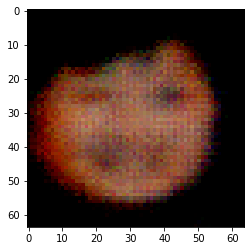

In [98]:
f_no = 560
family_data = generate_image(all_families[f_no][0], all_families[f_no][1], all_families[f_no][2])
inp = [family_data[0],family_data[1]]
inp = tf.cast(inp, tf.float32)

father_inp = inp[0][tf.newaxis,...]
mother_inp = inp[1][tf.newaxis,...]

with tf.device('/cpu:0'):
    gen_output = encoder([father_inp, mother_inp], training=True)
temp = gen_output.numpy()
plt.imshow(np.squeeze(temp))
# print(temp)
print(np.amin(temp))
print(np.amax(temp))

In [65]:
# family_data = generate_image(all_families[126])
# inp = [family_data[0],family_data[1]]
# inp = tf.cast(inp, tf.float32)
# with tf.device('/cpu:0'):
#     gen_output = encoder(inp, training=True)
# temp = gen_output.numpy()
# plt.imshow(np.squeeze(temp))
# # print(temp)
# print(np.amin(temp))
# print(np.amax(temp))

In [19]:
# family_data = generate_image(all_families[126])
# inp = [family_data[0],family_data[1]]
# inp = tf.cast(inp, tf.float32)
# with tf.device('/cpu:0'):
#     gen_output = encoder(inp, training=True)
# temp = gen_output.numpy()
# plt.imshow(np.squeeze(temp))
# # print(temp)
# print(np.amin(temp))
# print(np.amax(temp))

In [20]:
# family_data = generate_image(all_families[0])
# inp = [family_data[0],family_data[1]]
# inp = tf.cast(inp, tf.float32)
# with tf.device('/cpu:0'):
#     gen_output = encoder(inp, training=True)
# temp = gen_output.numpy()
# plt.imshow(np.squeeze(temp))
# # print(temp)
# print(np.amin(temp))
# print(np.amax(temp))

In [21]:
# family_data = generate_image(all_families[126])
# inp = [family_data[0],family_data[1]]
# inp = tf.cast(inp, tf.float32)
# with tf.device('/cpu:0'):
#     gen_output = encoder(inp, training=True)
# temp = gen_output.numpy()
# plt.imshow(np.squeeze(temp))
# # print(temp)
# print(np.amin(temp))
# print(np.amax(temp))

In [22]:
# family_data = generate_image(all_families[126])
# inp = [family_data[0],family_data[1]]
# inp = tf.cast(inp, tf.float32)
# with tf.device('/cpu:0'):
#     gen_output = encoder(inp, training=True)
# temp = gen_output.numpy()
# plt.imshow(np.squeeze(temp))
# # print(temp)
# print(np.amin(temp))
# print(np.amax(temp))

In [23]:
# family_data = generate_image(all_families[126])
# inp = [family_data[0],family_data[1]]
# inp = tf.cast(inp, tf.float32)
# with tf.device('/cpu:0'):
#     gen_output = encoder(inp, training=True)
# temp = gen_output.numpy()
# plt.imshow(np.squeeze(temp))
# # print(temp)
# print(np.amin(temp))
# print(np.amax(temp))

In [24]:
# family_data = generate_image(all_families[126])
# inp = [family_data[0],family_data[1]]
# inp = tf.cast(inp, tf.float32)
# with tf.device('/cpu:0'):
#     gen_output = encoder(inp, training=True)
# temp = gen_output.numpy()
# plt.imshow(np.squeeze(temp))
# # print(temp)
# print(np.amin(temp))
# print(np.amax(temp))

In [25]:
# # epochs = 10 bs 250 lr 0.002 mean = 0.02
# family_data = generate_image(all_families[700])
# inp = [family_data[0],family_data[1]]
# inp = tf.cast(inp, tf.float32)
# with tf.device('/cpu:0'):
#     gen_output = encoder(inp, training=False)
# temp = gen_output.numpy()
# plt.imshow(np.squeeze(temp))
# # print(temp)
# print(np.amin(temp))
# print(np.amax(temp))

In [26]:
# # epoch 10 batch = 250 mean 0.04 lr 1e-4 beta_1= 0.5
# family_data = generate_image(all_families[700])
# inp = [family_data[0],family_data[1]]
# inp = tf.cast(inp, tf.float32)
# with tf.device('/cpu:0'):
#     gen_output = encoder(inp, training=False)
# temp = gen_output.numpy()
# plt.imshow(np.squeeze(temp))
# # print(temp)
# print(np.amin(temp))
# print(np.amax(temp))

In [27]:
# # epoch 10 batch = 250 mean 0.02 lr 0.0005
# family_data = generate_image(all_families[700])
# inp = [family_data[0],family_data[1]]
# inp = tf.cast(inp, tf.float32)
# with tf.device('/cpu:0'):
#     gen_output = encoder(inp, training=False)
# temp = gen_output.numpy()
# plt.imshow(np.squeeze(temp))
# # print(temp)
# print(np.amin(temp))
# print(np.amax(temp))

In [28]:
# # epoch 20 batch = 400
# family_data = generate_image(all_families[700])
# inp = [family_data[0],family_data[1]]
# inp = tf.cast(inp, tf.float32)
# with tf.device('/cpu:0'):
#     gen_output = encoder(inp, training=False)
# temp = gen_output.numpy()
# plt.imshow(np.squeeze(temp))
# # print(temp)
# print(np.amin(temp))
# print(np.amax(temp))

In [29]:
# # epochs : 10 batch size 250
# family_data = generate_image(all_families[700])
# inp = [family_data[0],family_data[1]]
# inp = tf.cast(inp, tf.float32)
# with tf.device('/cpu:0'):
#     gen_output = encoder(inp, training=False)
# temp = gen_output.numpy()
# plt.imshow(np.squeeze(temp))
# # print(temp)
# print(np.amin(temp))
# print(np.amax(temp))

In [30]:
# #epochs = 4 batch_size : 250 
# family_data = generate_image(all_families[700])
# inp = [family_data[0],family_data[1]]
# inp = tf.cast(inp, tf.float32)
# with tf.device('/cpu:0'):
#     gen_output = encoder(inp, training=False)
# temp = gen_output.numpy()
# plt.imshow(np.squeeze(temp))
# # print(temp)
# print(np.amin(temp))
# print(np.amax(temp))

In [22]:
def disc_downsample_parent_target(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(mean, std_dev) 
  

    result = tf.keras.Sequential()
    result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer,
                             use_bias=False))

    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())
        
    result.add(tf.keras.layers.LeakyReLU(alpha = 0.2))

    return result

In [23]:
def disc_loss(filters, size,apply_batchnorm = False):
    initializer = tf.random_normal_initializer(mean, std_dev)

    result = tf.keras.Sequential()
    result.add(
    tf.keras.layers.Conv2D(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                   use_bias=False))
    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())
        
    result.add(tf.keras.layers.LeakyReLU(alpha = 0.2))
    
    return result

In [24]:
def Discriminator():

    father = tf.keras.layers.Input(shape=(64,64,3))
    mother = tf.keras.layers.Input(shape=(64,64,3))
    target = tf.keras.layers.Input(shape=(64,64,3))
    
    down_stack_parent_target = [
    disc_downsample_parent_target(32,4,apply_batchnorm=False),
    disc_downsample_parent_target(64,4,apply_batchnorm=True)
    ]
    
    down_stack_combined =[
    disc_loss(192,4,apply_batchnorm=True),
    disc_loss(256,4,apply_batchnorm=False)
    ]
    
    initializer = tf.random_normal_initializer(mean, sd_random_normal_init)
    last = tf.keras.layers.Conv2D(1, 4, strides=1,padding='same',
                                  kernel_initializer=initializer) # linear layer
    
    
    concat = tf.keras.layers.Concatenate()
    x1 = father
    for down in down_stack_parent_target:
        x1 = down(x1)
    
    x2 = mother
    for down in down_stack_parent_target:
        x2 = down(x2)
        
    x3 = target
    for down in down_stack_parent_target:
        x3 = down(x3)
    
    combined = concat([x1,x2,x3])
    # combined is 1x16x16x192
    
    x4 = combined
    for down in down_stack_combined:
        x4 = down(x4)
    
    output = last(x4) #4X4 
#     print(output.shape)

    return tf.keras.Model(inputs=[father,mother,target], outputs=output)

In [34]:
#discriminator = Discriminator()

In [35]:
# family_data = generate_image(all_families[126])
# p1 = tf.cast(family_data[0], tf.float32)
# p2 = tf.cast(family_data[1], tf.float32)
# c = tf.cast(family_data[2], tf.float32)

# discriminator = Discriminator()
# with tf.device('/cpu:0'):
#     disc_out = discriminator(inputs = [p1,p2,c], training=True)

In [36]:
LAMBDA = 0.1

In [37]:
loss_object = tf.keras.losses.BinaryCrossentropy()

In [38]:
def tensor_to_array(tensor1):
    return tensor1.numpy()

In [39]:
def discriminator_loss(disc_real_output, disc_generated_output):
    # real_loss = loss_object(tf.ones_like(disc_real_output,dtype=tf.float32), disc_real_output) #L1 loss
    real_loss = tf.reduce_mean(tf.abs(tf.ones_like(disc_real_output) - disc_real_output))
    generated_loss = tf.reduce_mean(tf.abs(tf.zeros_like(disc_generated_output) - disc_generated_output))
    # generated_loss = loss_object(tf.zeros_like(disc_generated_output,dtype=tf.float32), disc_generated_output) 
    total_disc_loss = real_loss + generated_loss
    print("D real loss: {}, D fake loss: {}".format(real_loss, generated_loss))
    return total_disc_loss

In [40]:
def generator_loss(disc_generated_output, gen_output, target):
    # gan_loss = loss_object(tf.ones_like(disc_generated_output,dtype=tf.float32), disc_generated_output)
    gan_loss = tf.reduce_mean(tf.abs(tf.ones_like(disc_generated_output) - disc_generated_output))
    # mean absolute error
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
    total_gen_loss = l1_loss #+ LAMBDA * gan_loss + 
    print("Reconstruction loss: {}, GAN loss: {}".format(l1_loss, gan_loss))
    return total_gen_loss

In [41]:
generator_optimizer = tf.keras.optimizers.Adam(lr, beta_1=b1)
discriminator_optimizer = tf.keras.optimizers.Adam(lr, beta_1=b1)

In [42]:
def train_step(father_batch, mother_batch, target_batch,b_size):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        
        gen_outputs = encoder([father_batch, mother_batch], training=True)
        print("Generated outputs",gen_outputs.shape)
        
        disc_real_output = discriminator([father_batch, mother_batch, target_batch], training=True)
        print("disc_real_output ", disc_real_output.shape)
        
        disc_generated_output = discriminator([father_batch, mother_batch, gen_outputs], training=True)
        print("disc_generated_output ", disc_generated_output.shape)
        
        gen_loss = generator_loss(disc_generated_output, gen_outputs, target_batch)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)
        
#         inp_batch = tf.unstack(inp_batch)
#         target_batch = tf.unstack(target_batch)

#         gen_loss =tf.Variable(0,dtype='float32')
#         disc_loss =tf.Variable(0,dtype='float32')
        
#         for idx,inputs in enumerate(inp_batch):
#             gen_output = encoder(inputs, training=True)
# #             gen_output shape is 1x64x64x3

#             disc_real_output = discriminator([inputs[0],inputs[1],target_batch[idx]], training=True)
# #             print(disc_real_output)
#             disc_generated_output = discriminator([inputs[0],inputs[1],tf.squeeze(gen_output)], training=True)
# #             print(disc_generated_output)
#             gen_loss = gen_loss + generator_loss(disc_generated_output, gen_output, target_batch[idx])
#             disc_loss = disc_loss + discriminator_loss(disc_real_output, disc_generated_output)


#         gen_loss/=b_size
#         disc_loss/=b_size
        
    print("GEN_LOSS",tensor_to_array(gen_loss))
    print("DISC_LOSS",tensor_to_array(disc_loss))

    generator_gradients = gen_tape.gradient(gen_loss,encoder.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss,discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_gradients,
                                          encoder.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

In [43]:
def fit(train_ds, epochs, test_ds,batch):
    for epoch in range(epochs):
        print("______________________________EPOCH %d_______________________________"%(epoch))
        start = time.time()
        for i in range(len(train_ds)//batch):
            batch_data = np.asarray(generate_batch(train_ds[i*batch:(i+1)*batch]))

            print("Generated batch", batch_data.shape)

            X_father_train = tf.convert_to_tensor(batch_data[:,0],dtype =tf.float32)
            X_mother_train = tf.convert_to_tensor(batch_data[:,1],dtype =tf.float32)
#             print("Xtrain",X_train.shape)
#             print("Batch converted to tensor")

            Y_train = tf.convert_to_tensor(batch_data[:,3],dtype =tf.float32)
            train_step(X_father_train, X_mother_train, Y_train, batch)
            print("Trained for batch %d/%d"%(i+1,(len(train_ds)//batch)))
            
        family_data = generate_image(all_families[700])
        inp = [family_data[0],family_data[1]]
        inp = tf.cast(inp, tf.float32)
        father_inp = inp[0][tf.newaxis,...]
        mother_inp = inp[1][tf.newaxis,...]
        gen_output = encoder([father_inp, mother_inp], training=True)
        
        print(tf.reduce_min(gen_output))
        print(tf.reduce_max(gen_output))
        plt.figure()
        plt.imshow(gen_output[0,...])
        plt.show()
    print("______________________________TRAINING COMPLETED_______________________________")
    checkpoint.save(file_prefix = checkpoint_prefix)

In [44]:
concat = tf.keras.layers.Concatenate()

In [45]:
train_dataset = all_families[:-500]
test_dataset = all_families[-500:]
encoder = EncoderNN()
discriminator = Discriminator()

In [46]:
checkpoint_dir = './checkpoint'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=encoder,
                                 discriminator=discriminator)

______________________________EPOCH 0_______________________________
Generated batch (64, 4, 64, 64, 3)
Generated outputs (64, 64, 64, 3)
disc_real_output  (64, 4, 4, 1)
disc_generated_output  (64, 4, 4, 1)
Reconstruction loss: 121.08928680419922, GAN loss: 1.0052673816680908
D real loss: 0.963925838470459, D fake loss: 0.31295573711395264
GEN_LOSS 121.08929
DISC_LOSS 1.2768816
Trained for batch 1/24
Generated batch (64, 4, 64, 64, 3)
Generated outputs (64, 64, 64, 3)
disc_real_output  (64, 4, 4, 1)
disc_generated_output  (64, 4, 4, 1)
Reconstruction loss: 127.51525115966797, GAN loss: 0.49007540941238403
D real loss: 0.45021235942840576, D fake loss: 0.6314404010772705
GEN_LOSS 127.51525
DISC_LOSS 1.0816528
Trained for batch 2/24
Generated batch (64, 4, 64, 64, 3)
Generated outputs (64, 64, 64, 3)
disc_real_output  (64, 4, 4, 1)
disc_generated_output  (64, 4, 4, 1)
Reconstruction loss: 133.78338623046875, GAN loss: 0.5136892795562744
D real loss: 0.39753326773643494, D fake loss: 0.53

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Trained for batch 24/24
tf.Tensor(-0.9765865, shape=(), dtype=float32)
tf.Tensor(0.70194304, shape=(), dtype=float32)


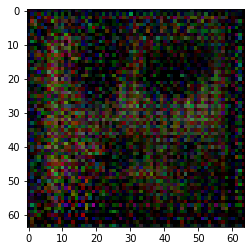

______________________________EPOCH 1_______________________________
Generated batch (64, 4, 64, 64, 3)
Generated outputs (64, 64, 64, 3)
disc_real_output  (64, 4, 4, 1)
disc_generated_output  (64, 4, 4, 1)
Reconstruction loss: 121.39437103271484, GAN loss: 1.0359549522399902
D real loss: 0.1993459016084671, D fake loss: 0.16550582647323608
GEN_LOSS 121.39437
DISC_LOSS 0.3648517
Trained for batch 1/24
Generated batch (64, 4, 64, 64, 3)
Generated outputs (64, 64, 64, 3)
disc_real_output  (64, 4, 4, 1)
disc_generated_output  (64, 4, 4, 1)
Reconstruction loss: 129.50291442871094, GAN loss: 0.9225922226905823
D real loss: 0.17453035712242126, D fake loss: 0.16754254698753357
GEN_LOSS 129.50291
DISC_LOSS 0.3420729
Trained for batch 2/24
Generated batch (64, 4, 64, 64, 3)
Generated outputs (64, 64, 64, 3)
disc_real_output  (64, 4, 4, 1)
disc_generated_output  (64, 4, 4, 1)
Reconstruction loss: 125.4954605102539, GAN loss: 1.0440294742584229
D real loss: 0.17440742254257202, D fake loss: 0.15

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Trained for batch 24/24
tf.Tensor(-0.9732646, shape=(), dtype=float32)
tf.Tensor(0.6670859, shape=(), dtype=float32)


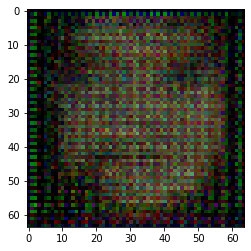

______________________________EPOCH 2_______________________________
Generated batch (64, 4, 64, 64, 3)
Generated outputs (64, 64, 64, 3)
disc_real_output  (64, 4, 4, 1)
disc_generated_output  (64, 4, 4, 1)
Reconstruction loss: 125.3439712524414, GAN loss: 0.9893038868904114
D real loss: 0.14550000429153442, D fake loss: 0.13369576632976532
GEN_LOSS 125.34397
DISC_LOSS 0.2791958
Trained for batch 1/24
Generated batch (64, 4, 64, 64, 3)
Generated outputs (64, 64, 64, 3)
disc_real_output  (64, 4, 4, 1)
disc_generated_output  (64, 4, 4, 1)
Reconstruction loss: 127.08629608154297, GAN loss: 0.9834662675857544
D real loss: 0.13521826267242432, D fake loss: 0.12817040085792542
GEN_LOSS 127.086296
DISC_LOSS 0.26338866
Trained for batch 2/24
Generated batch (64, 4, 64, 64, 3)
Generated outputs (64, 64, 64, 3)
disc_real_output  (64, 4, 4, 1)
disc_generated_output  (64, 4, 4, 1)
Reconstruction loss: 128.2769012451172, GAN loss: 0.9957531690597534
D real loss: 0.12596295773983002, D fake loss: 0.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Trained for batch 24/24
tf.Tensor(-0.95177186, shape=(), dtype=float32)
tf.Tensor(0.63221526, shape=(), dtype=float32)


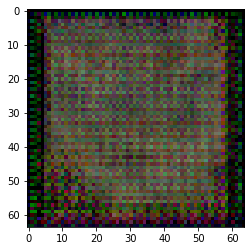

______________________________EPOCH 3_______________________________
Generated batch (64, 4, 64, 64, 3)
Generated outputs (64, 64, 64, 3)
disc_real_output  (64, 4, 4, 1)
disc_generated_output  (64, 4, 4, 1)
Reconstruction loss: 121.7061996459961, GAN loss: 0.9361358880996704
D real loss: 0.11637891083955765, D fake loss: 0.11330605298280716
GEN_LOSS 121.7062
DISC_LOSS 0.22968496
Trained for batch 1/24
Generated batch (64, 4, 64, 64, 3)
Generated outputs (64, 64, 64, 3)
disc_real_output  (64, 4, 4, 1)
disc_generated_output  (64, 4, 4, 1)
Reconstruction loss: 128.59323120117188, GAN loss: 1.070468544960022
D real loss: 0.13720235228538513, D fake loss: 0.12225121259689331
GEN_LOSS 128.59323
DISC_LOSS 0.25945356
Trained for batch 2/24
Generated batch (64, 4, 64, 64, 3)
Generated outputs (64, 64, 64, 3)
disc_real_output  (64, 4, 4, 1)
disc_generated_output  (64, 4, 4, 1)
Reconstruction loss: 126.80777740478516, GAN loss: 0.8665575981140137
D real loss: 0.151517853140831, D fake loss: 0.153

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Trained for batch 24/24
tf.Tensor(-0.9133114, shape=(), dtype=float32)
tf.Tensor(0.6844389, shape=(), dtype=float32)


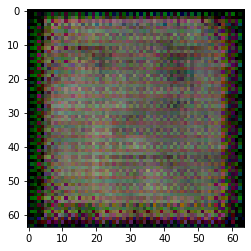

______________________________EPOCH 4_______________________________
Generated batch (64, 4, 64, 64, 3)
Generated outputs (64, 64, 64, 3)
disc_real_output  (64, 4, 4, 1)
disc_generated_output  (64, 4, 4, 1)
Reconstruction loss: 123.18389129638672, GAN loss: 0.8852906823158264
D real loss: 0.11501403152942657, D fake loss: 0.12960919737815857
GEN_LOSS 123.18389
DISC_LOSS 0.24462323
Trained for batch 1/24
Generated batch (64, 4, 64, 64, 3)
Generated outputs (64, 64, 64, 3)
disc_real_output  (64, 4, 4, 1)
disc_generated_output  (64, 4, 4, 1)
Reconstruction loss: 125.88823699951172, GAN loss: 1.0770612955093384
D real loss: 0.11454787850379944, D fake loss: 0.10377413034439087
GEN_LOSS 125.88824
DISC_LOSS 0.21832201
Trained for batch 2/24
Generated batch (64, 4, 64, 64, 3)
Generated outputs (64, 64, 64, 3)
disc_real_output  (64, 4, 4, 1)
disc_generated_output  (64, 4, 4, 1)
Reconstruction loss: 126.76871490478516, GAN loss: 0.9090961217880249
D real loss: 0.12379816919565201, D fake loss: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Trained for batch 24/24
tf.Tensor(-0.85312724, shape=(), dtype=float32)
tf.Tensor(0.7208562, shape=(), dtype=float32)


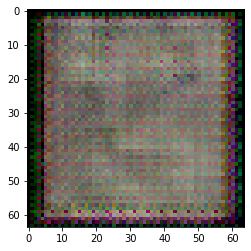

______________________________EPOCH 5_______________________________
Generated batch (64, 4, 64, 64, 3)
Generated outputs (64, 64, 64, 3)
disc_real_output  (64, 4, 4, 1)
disc_generated_output  (64, 4, 4, 1)
Reconstruction loss: 123.9851303100586, GAN loss: 0.9006310701370239
D real loss: 0.09847772866487503, D fake loss: 0.11350102722644806
GEN_LOSS 123.98513
DISC_LOSS 0.21197876
Trained for batch 1/24
Generated batch (64, 4, 64, 64, 3)
Generated outputs (64, 64, 64, 3)
disc_real_output  (64, 4, 4, 1)
disc_generated_output  (64, 4, 4, 1)
Reconstruction loss: 126.04135131835938, GAN loss: 1.044365644454956
D real loss: 0.09976351261138916, D fake loss: 0.08952160179615021
GEN_LOSS 126.04135
DISC_LOSS 0.18928511
Trained for batch 2/24
Generated batch (64, 4, 64, 64, 3)
Generated outputs (64, 64, 64, 3)
disc_real_output  (64, 4, 4, 1)
disc_generated_output  (64, 4, 4, 1)
Reconstruction loss: 127.5143051147461, GAN loss: 0.9535413384437561
D real loss: 0.09470492601394653, D fake loss: 0.0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Trained for batch 24/24
tf.Tensor(-0.82737285, shape=(), dtype=float32)
tf.Tensor(0.8068963, shape=(), dtype=float32)


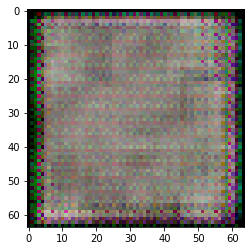

______________________________EPOCH 6_______________________________
Generated batch (64, 4, 64, 64, 3)
Generated outputs (64, 64, 64, 3)
disc_real_output  (64, 4, 4, 1)
disc_generated_output  (64, 4, 4, 1)
Reconstruction loss: 120.90006256103516, GAN loss: 0.9427186250686646
D real loss: 0.08324098587036133, D fake loss: 0.08813920617103577
GEN_LOSS 120.90006
DISC_LOSS 0.17138019
Trained for batch 1/24
Generated batch (64, 4, 64, 64, 3)
Generated outputs (64, 64, 64, 3)
disc_real_output  (64, 4, 4, 1)
disc_generated_output  (64, 4, 4, 1)
Reconstruction loss: 131.0999755859375, GAN loss: 1.0335431098937988
D real loss: 0.08516295999288559, D fake loss: 0.08559790998697281
GEN_LOSS 131.09998
DISC_LOSS 0.17076087
Trained for batch 2/24
Generated batch (64, 4, 64, 64, 3)
Generated outputs (64, 64, 64, 3)
disc_real_output  (64, 4, 4, 1)
disc_generated_output  (64, 4, 4, 1)
Reconstruction loss: 128.2293243408203, GAN loss: 1.0049136877059937
D real loss: 0.08278873562812805, D fake loss: 0.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Trained for batch 24/24
tf.Tensor(-0.83114415, shape=(), dtype=float32)
tf.Tensor(0.8234435, shape=(), dtype=float32)


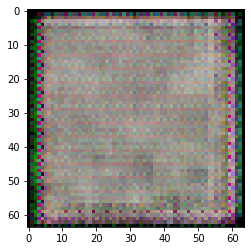

______________________________EPOCH 7_______________________________
Generated batch (64, 4, 64, 64, 3)
Generated outputs (64, 64, 64, 3)
disc_real_output  (64, 4, 4, 1)
disc_generated_output  (64, 4, 4, 1)
Reconstruction loss: 123.3524398803711, GAN loss: 1.0608539581298828
D real loss: 0.08710335940122604, D fake loss: 0.08504075556993484
GEN_LOSS 123.35244
DISC_LOSS 0.17214411
Trained for batch 1/24
Generated batch (64, 4, 64, 64, 3)
Generated outputs (64, 64, 64, 3)
disc_real_output  (64, 4, 4, 1)
disc_generated_output  (64, 4, 4, 1)
Reconstruction loss: 125.44763946533203, GAN loss: 0.9392133951187134
D real loss: 0.08605951070785522, D fake loss: 0.08073820173740387
GEN_LOSS 125.44764
DISC_LOSS 0.16679771
Trained for batch 2/24
Generated batch (64, 4, 64, 64, 3)
Generated outputs (64, 64, 64, 3)
disc_real_output  (64, 4, 4, 1)
disc_generated_output  (64, 4, 4, 1)
Reconstruction loss: 125.2983169555664, GAN loss: 1.062303900718689
D real loss: 0.0824371948838234, D fake loss: 0.08

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Trained for batch 24/24
tf.Tensor(-0.81083405, shape=(), dtype=float32)
tf.Tensor(0.86234105, shape=(), dtype=float32)


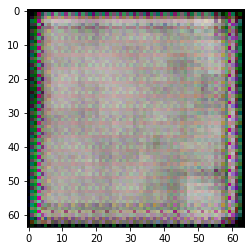

______________________________EPOCH 8_______________________________
Generated batch (64, 4, 64, 64, 3)
Generated outputs (64, 64, 64, 3)
disc_real_output  (64, 4, 4, 1)
disc_generated_output  (64, 4, 4, 1)
Reconstruction loss: 122.2465591430664, GAN loss: 0.9328069686889648
D real loss: 0.07872109115123749, D fake loss: 0.08184120059013367
GEN_LOSS 122.24656
DISC_LOSS 0.16056229
Trained for batch 1/24
Generated batch (64, 4, 64, 64, 3)
Generated outputs (64, 64, 64, 3)
disc_real_output  (64, 4, 4, 1)
disc_generated_output  (64, 4, 4, 1)
Reconstruction loss: 123.00508880615234, GAN loss: 1.0641777515411377
D real loss: 0.09610925614833832, D fake loss: 0.0790235623717308
GEN_LOSS 123.00509
DISC_LOSS 0.17513281
Trained for batch 2/24
Generated batch (64, 4, 64, 64, 3)
Generated outputs (64, 64, 64, 3)
disc_real_output  (64, 4, 4, 1)
disc_generated_output  (64, 4, 4, 1)
Reconstruction loss: 125.00797271728516, GAN loss: 0.9325946569442749
D real loss: 0.09207133948802948, D fake loss: 0.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Trained for batch 24/24
tf.Tensor(-0.8461245, shape=(), dtype=float32)
tf.Tensor(0.8945863, shape=(), dtype=float32)


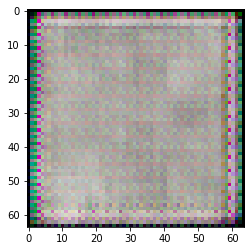

______________________________EPOCH 9_______________________________
Generated batch (64, 4, 64, 64, 3)
Generated outputs (64, 64, 64, 3)
disc_real_output  (64, 4, 4, 1)
disc_generated_output  (64, 4, 4, 1)
Reconstruction loss: 123.56017303466797, GAN loss: 0.9701284170150757
D real loss: 0.06662623584270477, D fake loss: 0.06128052622079849
GEN_LOSS 123.56017
DISC_LOSS 0.12790677
Trained for batch 1/24
Generated batch (64, 4, 64, 64, 3)
Generated outputs (64, 64, 64, 3)
disc_real_output  (64, 4, 4, 1)
disc_generated_output  (64, 4, 4, 1)
Reconstruction loss: 127.92037200927734, GAN loss: 1.0360240936279297
D real loss: 0.06836830079555511, D fake loss: 0.06840831786394119
GEN_LOSS 127.92037
DISC_LOSS 0.13677663
Trained for batch 2/24
Generated batch (64, 4, 64, 64, 3)
Generated outputs (64, 64, 64, 3)
disc_real_output  (64, 4, 4, 1)
disc_generated_output  (64, 4, 4, 1)
Reconstruction loss: 130.1404571533203, GAN loss: 0.9672565460205078
D real loss: 0.06947790086269379, D fake loss: 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Trained for batch 24/24
tf.Tensor(-0.768143, shape=(), dtype=float32)
tf.Tensor(0.90482724, shape=(), dtype=float32)


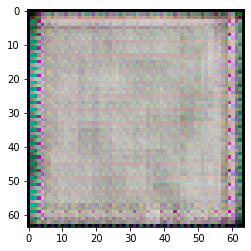

______________________________EPOCH 10_______________________________
Generated batch (64, 4, 64, 64, 3)
Generated outputs (64, 64, 64, 3)
disc_real_output  (64, 4, 4, 1)
disc_generated_output  (64, 4, 4, 1)
Reconstruction loss: 125.15231323242188, GAN loss: 0.9593163132667542
D real loss: 0.06476239860057831, D fake loss: 0.06660216301679611
GEN_LOSS 125.15231
DISC_LOSS 0.13136455
Trained for batch 1/24
Generated batch (64, 4, 64, 64, 3)
Generated outputs (64, 64, 64, 3)
disc_real_output  (64, 4, 4, 1)
disc_generated_output  (64, 4, 4, 1)
Reconstruction loss: 124.9017562866211, GAN loss: 1.0088021755218506
D real loss: 0.06360526382923126, D fake loss: 0.05229875445365906
GEN_LOSS 124.90176
DISC_LOSS 0.11590402
Trained for batch 2/24
Generated batch (64, 4, 64, 64, 3)
Generated outputs (64, 64, 64, 3)
disc_real_output  (64, 4, 4, 1)
disc_generated_output  (64, 4, 4, 1)
Reconstruction loss: 123.8199462890625, GAN loss: 1.0017014741897583
D real loss: 0.061729684472084045, D fake loss: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Trained for batch 24/24
tf.Tensor(-0.753574, shape=(), dtype=float32)
tf.Tensor(0.90498513, shape=(), dtype=float32)


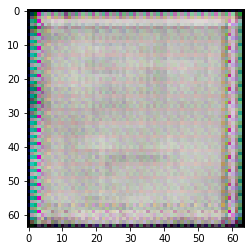

______________________________EPOCH 11_______________________________
Generated batch (64, 4, 64, 64, 3)
Generated outputs (64, 64, 64, 3)
disc_real_output  (64, 4, 4, 1)
disc_generated_output  (64, 4, 4, 1)
Reconstruction loss: 126.0001220703125, GAN loss: 0.9173042178153992
D real loss: 0.07639764249324799, D fake loss: 0.08836030960083008
GEN_LOSS 126.00012
DISC_LOSS 0.16475795
Trained for batch 1/24
Generated batch (64, 4, 64, 64, 3)
Generated outputs (64, 64, 64, 3)
disc_real_output  (64, 4, 4, 1)
disc_generated_output  (64, 4, 4, 1)
Reconstruction loss: 130.79002380371094, GAN loss: 1.0690919160842896
D real loss: 0.07609480619430542, D fake loss: 0.07878964394330978
GEN_LOSS 130.79002
DISC_LOSS 0.15488446
Trained for batch 2/24
Generated batch (64, 4, 64, 64, 3)
Generated outputs (64, 64, 64, 3)
disc_real_output  (64, 4, 4, 1)
disc_generated_output  (64, 4, 4, 1)
Reconstruction loss: 125.5468978881836, GAN loss: 0.9435800313949585
D real loss: 0.08116985857486725, D fake loss: 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Trained for batch 24/24
tf.Tensor(-0.7360026, shape=(), dtype=float32)
tf.Tensor(0.93436515, shape=(), dtype=float32)


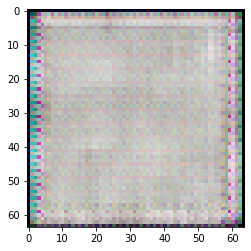

______________________________EPOCH 12_______________________________
Generated batch (64, 4, 64, 64, 3)
Generated outputs (64, 64, 64, 3)
disc_real_output  (64, 4, 4, 1)
disc_generated_output  (64, 4, 4, 1)
Reconstruction loss: 117.3335189819336, GAN loss: 1.04978609085083
D real loss: 0.08706951141357422, D fake loss: 0.06756970286369324
GEN_LOSS 117.33352
DISC_LOSS 0.15463921
Trained for batch 1/24
Generated batch (64, 4, 64, 64, 3)
Generated outputs (64, 64, 64, 3)
disc_real_output  (64, 4, 4, 1)
disc_generated_output  (64, 4, 4, 1)
Reconstruction loss: 124.05023193359375, GAN loss: 0.9172404408454895
D real loss: 0.09584054350852966, D fake loss: 0.08610814064741135
GEN_LOSS 124.05023
DISC_LOSS 0.18194869
Trained for batch 2/24
Generated batch (64, 4, 64, 64, 3)
Generated outputs (64, 64, 64, 3)
disc_real_output  (64, 4, 4, 1)
disc_generated_output  (64, 4, 4, 1)
Reconstruction loss: 125.2263412475586, GAN loss: 1.0871599912643433
D real loss: 0.09821043908596039, D fake loss: 0.0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Trained for batch 24/24
tf.Tensor(-0.66512775, shape=(), dtype=float32)
tf.Tensor(0.9486873, shape=(), dtype=float32)


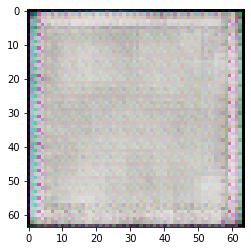

______________________________EPOCH 13_______________________________
Generated batch (64, 4, 64, 64, 3)
Generated outputs (64, 64, 64, 3)
disc_real_output  (64, 4, 4, 1)
disc_generated_output  (64, 4, 4, 1)
Reconstruction loss: 117.72771453857422, GAN loss: 1.0750086307525635
D real loss: 0.09904379397630692, D fake loss: 0.08091425150632858
GEN_LOSS 117.727715
DISC_LOSS 0.17995805
Trained for batch 1/24
Generated batch (64, 4, 64, 64, 3)
Generated outputs (64, 64, 64, 3)
disc_real_output  (64, 4, 4, 1)
disc_generated_output  (64, 4, 4, 1)
Reconstruction loss: 125.45266723632812, GAN loss: 0.9380506277084351
D real loss: 0.07256456464529037, D fake loss: 0.06918831914663315
GEN_LOSS 125.45267
DISC_LOSS 0.14175288
Trained for batch 2/24
Generated batch (64, 4, 64, 64, 3)
Generated outputs (64, 64, 64, 3)
disc_real_output  (64, 4, 4, 1)
disc_generated_output  (64, 4, 4, 1)
Reconstruction loss: 125.25948333740234, GAN loss: 1.050121784210205
D real loss: 0.06507118046283722, D fake loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Trained for batch 24/24
tf.Tensor(-0.56246614, shape=(), dtype=float32)
tf.Tensor(0.94712234, shape=(), dtype=float32)


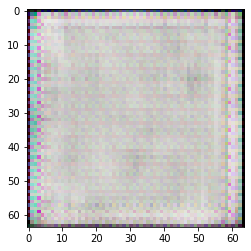

______________________________EPOCH 14_______________________________
Generated batch (64, 4, 64, 64, 3)
Generated outputs (64, 64, 64, 3)
disc_real_output  (64, 4, 4, 1)
disc_generated_output  (64, 4, 4, 1)
Reconstruction loss: 124.9610595703125, GAN loss: 1.0199921131134033
D real loss: 0.05945365130901337, D fake loss: 0.052183277904987335
GEN_LOSS 124.96106
DISC_LOSS 0.11163693
Trained for batch 1/24
Generated batch (64, 4, 64, 64, 3)
Generated outputs (64, 64, 64, 3)
disc_real_output  (64, 4, 4, 1)
disc_generated_output  (64, 4, 4, 1)
Reconstruction loss: 129.3795166015625, GAN loss: 0.9728659987449646
D real loss: 0.05630353093147278, D fake loss: 0.0484362356364727
GEN_LOSS 129.37952
DISC_LOSS 0.10473977
Trained for batch 2/24
Generated batch (64, 4, 64, 64, 3)
Generated outputs (64, 64, 64, 3)
disc_real_output  (64, 4, 4, 1)
disc_generated_output  (64, 4, 4, 1)
Reconstruction loss: 126.45687103271484, GAN loss: 1.0409564971923828
D real loss: 0.0643424391746521, D fake loss: 0.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Trained for batch 24/24
tf.Tensor(-0.44462228, shape=(), dtype=float32)
tf.Tensor(0.94978, shape=(), dtype=float32)


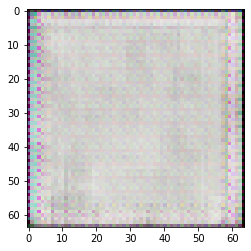

______________________________EPOCH 15_______________________________
Generated batch (64, 4, 64, 64, 3)
Generated outputs (64, 64, 64, 3)
disc_real_output  (64, 4, 4, 1)
disc_generated_output  (64, 4, 4, 1)
Reconstruction loss: 121.95999908447266, GAN loss: 1.0550122261047363
D real loss: 0.07238557189702988, D fake loss: 0.06491507589817047
GEN_LOSS 121.96
DISC_LOSS 0.13730064
Trained for batch 1/24
Generated batch (64, 4, 64, 64, 3)
Generated outputs (64, 64, 64, 3)
disc_real_output  (64, 4, 4, 1)
disc_generated_output  (64, 4, 4, 1)
Reconstruction loss: 127.02225494384766, GAN loss: 0.9282131791114807
D real loss: 0.08582209050655365, D fake loss: 0.0755709558725357
GEN_LOSS 127.022255
DISC_LOSS 0.16139305
Trained for batch 2/24
Generated batch (64, 4, 64, 64, 3)
Generated outputs (64, 64, 64, 3)
disc_real_output  (64, 4, 4, 1)
disc_generated_output  (64, 4, 4, 1)
Reconstruction loss: 125.87482452392578, GAN loss: 1.0731728076934814
D real loss: 0.08055970817804337, D fake loss: 0.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Trained for batch 24/24
tf.Tensor(-0.34075978, shape=(), dtype=float32)
tf.Tensor(0.94990385, shape=(), dtype=float32)


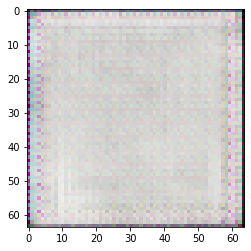

______________________________EPOCH 16_______________________________
Generated batch (64, 4, 64, 64, 3)
Generated outputs (64, 64, 64, 3)
disc_real_output  (64, 4, 4, 1)
disc_generated_output  (64, 4, 4, 1)
Reconstruction loss: 125.28218841552734, GAN loss: 1.0489052534103394
D real loss: 0.07430143654346466, D fake loss: 0.056844308972358704
GEN_LOSS 125.28219
DISC_LOSS 0.13114575
Trained for batch 1/24
Generated batch (64, 4, 64, 64, 3)
Generated outputs (64, 64, 64, 3)
disc_real_output  (64, 4, 4, 1)
disc_generated_output  (64, 4, 4, 1)
Reconstruction loss: 125.9581069946289, GAN loss: 0.9341729283332825
D real loss: 0.06424959003925323, D fake loss: 0.0699765533208847
GEN_LOSS 125.95811
DISC_LOSS 0.13422614
Trained for batch 2/24
Generated batch (64, 4, 64, 64, 3)
Generated outputs (64, 64, 64, 3)
disc_real_output  (64, 4, 4, 1)
disc_generated_output  (64, 4, 4, 1)
Reconstruction loss: 119.4268798828125, GAN loss: 1.0414549112319946
D real loss: 0.06422366201877594, D fake loss: 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Trained for batch 24/24
tf.Tensor(-0.17415653, shape=(), dtype=float32)
tf.Tensor(0.9477318, shape=(), dtype=float32)


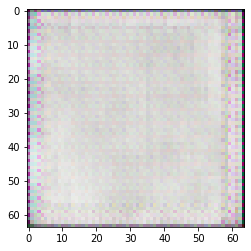

______________________________EPOCH 17_______________________________
Generated batch (64, 4, 64, 64, 3)
Generated outputs (64, 64, 64, 3)
disc_real_output  (64, 4, 4, 1)
disc_generated_output  (64, 4, 4, 1)
Reconstruction loss: 125.95563507080078, GAN loss: 1.0394549369812012
D real loss: 0.06219661235809326, D fake loss: 0.0504658967256546
GEN_LOSS 125.955635
DISC_LOSS 0.11266251
Trained for batch 1/24
Generated batch (64, 4, 64, 64, 3)
Generated outputs (64, 64, 64, 3)
disc_real_output  (64, 4, 4, 1)
disc_generated_output  (64, 4, 4, 1)
Reconstruction loss: 122.97257232666016, GAN loss: 0.9441624879837036
D real loss: 0.06484071910381317, D fake loss: 0.0614665225148201
GEN_LOSS 122.97257
DISC_LOSS 0.12630725
Trained for batch 2/24
Generated batch (64, 4, 64, 64, 3)
Generated outputs (64, 64, 64, 3)
disc_real_output  (64, 4, 4, 1)
disc_generated_output  (64, 4, 4, 1)
Reconstruction loss: 125.2615966796875, GAN loss: 1.047780990600586
D real loss: 0.06246389448642731, D fake loss: 0.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Trained for batch 24/24
tf.Tensor(-0.0030323842, shape=(), dtype=float32)
tf.Tensor(0.95815885, shape=(), dtype=float32)


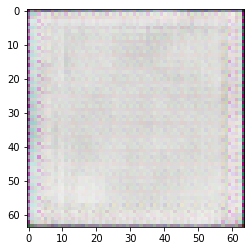

______________________________EPOCH 18_______________________________
Generated batch (64, 4, 64, 64, 3)
Generated outputs (64, 64, 64, 3)
disc_real_output  (64, 4, 4, 1)
disc_generated_output  (64, 4, 4, 1)
Reconstruction loss: 123.82364654541016, GAN loss: 0.9924707412719727
D real loss: 0.04879274219274521, D fake loss: 0.04287626966834068
GEN_LOSS 123.82365
DISC_LOSS 0.09166901
Trained for batch 1/24
Generated batch (64, 4, 64, 64, 3)
Generated outputs (64, 64, 64, 3)
disc_real_output  (64, 4, 4, 1)
disc_generated_output  (64, 4, 4, 1)
Reconstruction loss: 128.19065856933594, GAN loss: 1.0188677310943604
D real loss: 0.04984108358621597, D fake loss: 0.045451030135154724
GEN_LOSS 128.19066
DISC_LOSS 0.09529211
Trained for batch 2/24
Generated batch (64, 4, 64, 64, 3)
Generated outputs (64, 64, 64, 3)
disc_real_output  (64, 4, 4, 1)
disc_generated_output  (64, 4, 4, 1)
Reconstruction loss: 126.7585220336914, GAN loss: 0.9798211455345154
D real loss: 0.049978889524936676, D fake loss

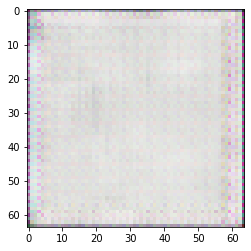

______________________________EPOCH 19_______________________________
Generated batch (64, 4, 64, 64, 3)
Generated outputs (64, 64, 64, 3)
disc_real_output  (64, 4, 4, 1)
disc_generated_output  (64, 4, 4, 1)
Reconstruction loss: 122.67050170898438, GAN loss: 0.9603273868560791
D real loss: 0.0531027689576149, D fake loss: 0.0516081228852272
GEN_LOSS 122.6705
DISC_LOSS 0.10471089
Trained for batch 1/24
Generated batch (64, 4, 64, 64, 3)
Generated outputs (64, 64, 64, 3)
disc_real_output  (64, 4, 4, 1)
disc_generated_output  (64, 4, 4, 1)
Reconstruction loss: 126.0766372680664, GAN loss: 1.0504800081253052
D real loss: 0.054912835359573364, D fake loss: 0.056405745446681976
GEN_LOSS 126.07664
DISC_LOSS 0.11131858
Trained for batch 2/24
Generated batch (64, 4, 64, 64, 3)
Generated outputs (64, 64, 64, 3)
disc_real_output  (64, 4, 4, 1)
disc_generated_output  (64, 4, 4, 1)
Reconstruction loss: 127.8161392211914, GAN loss: 0.9557225704193115
D real loss: 0.052460864186286926, D fake loss: 0

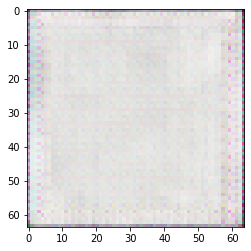

______________________________TRAINING COMPLETED_______________________________


In [47]:
with tf.device('/cpu:0'):
    fit(train_dataset, EPOCHS, test_dataset,batch)

In [48]:
family_data = generate_image(all_families[1])
inp = [family_data[0],family_data[1]]
inp = tf.cast(inp, tf.float32)
with tf.device('/cpu:0'):
    gen_output = encoder(inp, training=True)
print(tf.reduce_min(gen_output))
print(tf.reduce_max(gen_output))
plt.imshow(gen_output[0,...])

AssertionError: Could not compute output Tensor("conv2d_transpose_7/Identity:0", shape=(None, 64, 64, 3), dtype=float32)